In [2]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.utils import to_undirected
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from tqdm import tqdm
from safetensors.torch import save_model

c:\Users\paoma\miniconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\paoma\miniconda3\lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [3]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = "cpu"

### Data Processing

In [4]:
df = pd.read_csv('signs_en.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,Landmark 1 x,Landmark 1 y,Landmark 2 x,Landmark 2 y,Landmark 3 x,Landmark 3 y,Landmark 4 x,Landmark 4 y,...,Landmark 16 y,Landmark 17 x,Landmark 17 y,Landmark 18 x,Landmark 18 y,Landmark 19 x,Landmark 19 y,Landmark 20 x,Landmark 20 y,Label
0,0,0.0,0.447142,0.590708,0.469595,0.513098,0.471293,0.451205,0.455870,0.405068,...,0.630833,0.518164,0.645377,0.555401,0.660619,0.535724,0.671495,0.516766,0.669519,good
1,1,1.0,0.447354,0.598270,0.470890,0.518473,0.474211,0.456242,0.458783,0.407200,...,0.634632,0.518493,0.648955,0.557850,0.663069,0.536107,0.673253,0.514505,0.670299,good
2,2,2.0,0.447751,0.594389,0.471821,0.516508,0.474668,0.455287,0.459516,0.407649,...,0.634539,0.519102,0.647704,0.561070,0.663423,0.539275,0.672495,0.516909,0.668556,good
3,3,3.0,0.447579,0.594926,0.471340,0.515999,0.474191,0.453736,0.458233,0.405407,...,0.636172,0.520290,0.647888,0.561078,0.664179,0.539073,0.673748,0.516713,0.669505,good
4,4,4.0,0.448942,0.590661,0.472229,0.511420,0.474214,0.448855,0.457358,0.401411,...,0.629209,0.520169,0.637428,0.560247,0.658442,0.537632,0.668001,0.514961,0.662070,good


In [5]:
df = df.sample(frac=1, random_state=42)
df.head()

,Unnamed: 0.1,Unnamed: 0,Landmark 1 x,Landmark 1 y,Landmark 2 x,Landmark 2 y,Landmark 3 x,Landmark 3 y,Landmark 4 x,Landmark 4 y,...,Landmark 16 y,Landmark 17 x,Landmark 17 y,Landmark 18 x,Landmark 18 y,Landmark 19 x,Landmark 19 y,Landmark 20 x,Landmark 20 y,Label
415,415,86.0,0.326569,0.674404,0.357834,0.703072,0.375689,0.741255,0.382552,0.776034,...,0.606782,0.336321,0.575292,0.347091,0.577000,0.336864,0.592053,0.330558,0.594813,not good
2927,588,NaN,0.456985,0.661305,0.467504,0.639797,0.480497,0.630084,0.492144,0.625483,...,0.629676,0.457430,0.617761,0.481457,0.615641,0.491817,0.621171,0.497802,0.628334,c
3194,855,NaN,0.431389,0.722176,0.459923,0.701749,0.483064,0.689345,0.492661,0.675986,...,0.582822,0.423682,0.622943,0.434341,0.581182,0.455356,0.578791,0.470810,0.590627,c
298,298,298.0,0.378981,0.597129,0.397010,0.543736,0.398701,0.502422,0.384802,0.473080,...,0.610331,0.440011,0.626854,0.469402,0.634171,0.454586,0.641440,0.438621,0.639632,good
1874,634,NaN,0.443326,0.806144,0.465649,0.758831,0.444961,0.711449,0.419999,0.689627,...,0.541464,0.397769,0.688573,0.404561,0.640295,0.408814,0.610057,0.412891,0.581599,b


In [6]:
features = df.drop(columns=['Label', 'Unnamed: 0.1', 'Unnamed: 0'])
features.shape

(3644, 40)

In [7]:
labels = df['Label']
labels.unique()

array(['not good', 'c', 'good', 'b', 'okay', 'a'], dtype=object)

In [8]:
le = LabelEncoder()
labels = le.fit_transform(labels)
joblib.dump(le, 'label_encoder.pkl')

labels.shape

(3644,)

![](hand_landmarks.png)

Edge index of hand landmarks are constant. Edge index is a 2D matrix with 2 rows. First row represents origin and second row represents end. Per column, it lists all the connections the graph makes. Essentially it is one of the matrix representations of a graph. Undirected does both a to b and b to a.

In [121]:
# make edge index
edge_index = torch.tensor([
    [0, 1, 2, 4, 4, 5, 6, 8, 8, 9, 10, 12, 12, 13, 14, 16, 17, 18],
    [1, 2, 3, 5, 8, 6, 7, 9, 12, 10, 11, 16, 13, 14, 15, 17, 18, 19]
    ], dtype=torch.long).to(device)

# make it undirected
edge_index = to_undirected(edge_index)

In [122]:
features = features.to_numpy()
features = features.reshape(-1, 20, 2)

In [123]:
datas = []
for i in range(len(features)):
    data = Data(
        x=torch.tensor(features[i], dtype=torch.float).to(device), 
        edge_index=edge_index,
        y=torch.tensor(labels[i], dtype=torch.long).to(device)
    )
    datas.append(data)

In [124]:
split = int(len(datas) * 0.8)

train_dl = DataLoader(datas[:split], batch_size=32)
test_dl = DataLoader(datas[split:], batch_size=32)

In [125]:
sample = next(iter(train_dl))
sample

DataBatch(x=[640, 2], edge_index=[2, 1152], y=[32], batch=[640], ptr=[33])

### Model Creation

In [126]:
class GCN(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, output_channels)
        
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GCN(2, 32, 6).to(device)
print(model)

GCN(
  (conv1): GCNConv(2, 32)
  (conv2): GCNConv(32, 32)
  (lin): Linear(in_features=32, out_features=6, bias=True)
)


In [127]:
model(sample.x, sample.edge_index, sample.batch)

tensor([[ 0.0990,  0.0260, -0.0387, -0.0342,  0.1917,  0.1092],
        [ 0.0507, -0.0055, -0.0705, -0.0059,  0.2679, -0.0081],
        [ 0.1984,  0.0720, -0.0966, -0.0396,  0.2021,  0.1317],
        [ 0.0530, -0.0016, -0.0413, -0.0531,  0.0049, -0.0783],
        [ 0.1934,  0.0613, -0.0499,  0.0804,  0.0913,  0.1826],
        [ 0.1669, -0.0180, -0.1554, -0.1657,  0.2688,  0.0921],
        [ 0.0672,  0.0533,  0.0542,  0.0488,  0.2480, -0.0137],
        [ 0.1050,  0.0594,  0.0403,  0.0925, -0.0565,  0.0275],
        [ 0.1622,  0.0744,  0.0719,  0.0013,  0.1831, -0.0409],
        [ 0.1029, -0.0688, -0.2173,  0.0069,  0.1393,  0.1418],
        [-0.0267,  0.0751,  0.0005,  0.0435,  0.1181,  0.0292],
        [ 0.1108, -0.0444, -0.1571, -0.0569,  0.0429,  0.1958],
        [ 0.1557,  0.0656,  0.0633,  0.0882,  0.2534,  0.2618],
        [ 0.0772,  0.0594,  0.1176,  0.1184,  0.2976,  0.1368],
        [ 0.0663,  0.0181,  0.0774,  0.0435,  0.2314,  0.0046],
        [ 0.1171,  0.0177, -0.1365, -0.0

In [128]:
sample.y

tensor([4, 2, 2, 3, 1, 2, 3, 2, 2, 2, 5, 2, 2, 0, 1, 5, 0, 5, 5, 2, 5, 2, 3, 4,
        2, 3, 1, 3, 5, 0, 3, 1])

In [129]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

### Model Training

In [130]:
torch.manual_seed(42)

epochs = 100

train_losses = []
test_losses = []

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")
    
    # TRAINING
    train_loss =  0
    model.train()
    for data in train_dl:

        # forward pass
        pred = model(data.x, data.edge_index, data.batch)

        # metrics
        loss = loss_fn(pred, data.y)
        train_loss += loss

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print metrics
    train_loss /= len(train_dl)
    train_losses.append(train_loss.item())
    print(f"Train Loss: {train_loss:.4f}")


    # TESTING
    test_loss = 0
    model.eval()
    with torch.inference_mode():
        for data in test_dl:

            # forward pass
            pred = model(data.x, data.edge_index, data.batch)

            # metrics
            loss = loss_fn(pred, data.y)
            test_loss += loss

        # print metrics
        test_loss /= len(test_dl)
        test_losses.append(test_loss.item())
        print(f"Test Loss: {test_loss:.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
------


  1%|          | 1/100 [00:00<00:50,  1.97it/s]

Train Loss: 1.6197
Test Loss: 1.5393
Epoch: 1
------


  2%|▏         | 2/100 [00:00<00:44,  2.20it/s]

Train Loss: 1.3973
Test Loss: 1.2633
Epoch: 2
------


  3%|▎         | 3/100 [00:01<00:43,  2.25it/s]

Train Loss: 1.2336
Test Loss: 1.1455
Epoch: 3
------


  4%|▍         | 4/100 [00:01<00:45,  2.12it/s]

Train Loss: 1.1675
Test Loss: 1.0797
Epoch: 4
------


  5%|▌         | 5/100 [00:02<00:42,  2.21it/s]

Train Loss: 1.1286
Test Loss: 1.0829
Epoch: 5
------


  6%|▌         | 6/100 [00:02<00:41,  2.25it/s]

Train Loss: 1.0992
Test Loss: 1.0207
Epoch: 6
------


  7%|▋         | 7/100 [00:03<00:42,  2.21it/s]

Train Loss: 1.0582
Test Loss: 1.0130
Epoch: 7
------


  8%|▊         | 8/100 [00:03<00:43,  2.11it/s]

Train Loss: 1.0235
Test Loss: 0.9765
Epoch: 8
------


  9%|▉         | 9/100 [00:04<00:44,  2.05it/s]

Train Loss: 0.9973
Test Loss: 0.9250
Epoch: 9
------


 10%|█         | 10/100 [00:04<00:44,  2.02it/s]

Train Loss: 0.9642
Test Loss: 0.9436
Epoch: 10
------


 11%|█         | 11/100 [00:05<00:43,  2.02it/s]

Train Loss: 0.9648
Test Loss: 0.9106
Epoch: 11
------


 12%|█▏        | 12/100 [00:05<00:42,  2.08it/s]

Train Loss: 0.9403
Test Loss: 0.9479
Epoch: 12
------


 13%|█▎        | 13/100 [00:06<00:42,  2.06it/s]

Train Loss: 0.9143
Test Loss: 0.9471
Epoch: 13
------


 14%|█▍        | 14/100 [00:06<00:43,  1.99it/s]

Train Loss: 0.9121
Test Loss: 0.9015
Epoch: 14
------


 15%|█▌        | 15/100 [00:07<00:40,  2.07it/s]

Train Loss: 0.8935
Test Loss: 0.9434
Epoch: 15
------


 16%|█▌        | 16/100 [00:07<00:39,  2.13it/s]

Train Loss: 0.8957
Test Loss: 0.9218
Epoch: 16
------


 17%|█▋        | 17/100 [00:08<00:38,  2.16it/s]

Train Loss: 0.8888
Test Loss: 0.8419
Epoch: 17
------


 18%|█▊        | 18/100 [00:08<00:40,  2.04it/s]

Train Loss: 0.9076
Test Loss: 0.7573
Epoch: 18
------


 19%|█▉        | 19/100 [00:09<00:41,  1.96it/s]

Train Loss: 0.8727
Test Loss: 0.8568
Epoch: 19
------


 20%|██        | 20/100 [00:09<00:46,  1.73it/s]

Train Loss: 0.8657
Test Loss: 0.7721
Epoch: 20
------


 21%|██        | 21/100 [00:10<00:43,  1.80it/s]

Train Loss: 0.8622
Test Loss: 0.7654
Epoch: 21
------


 22%|██▏       | 22/100 [00:10<00:41,  1.90it/s]

Train Loss: 0.8471
Test Loss: 0.7651
Epoch: 22
------


 23%|██▎       | 23/100 [00:11<00:39,  1.97it/s]

Train Loss: 0.8493
Test Loss: 0.7581
Epoch: 23
------


 24%|██▍       | 24/100 [00:11<00:38,  1.97it/s]

Train Loss: 0.8251
Test Loss: 0.7937
Epoch: 24
------


 25%|██▌       | 25/100 [00:12<00:37,  2.01it/s]

Train Loss: 0.8327
Test Loss: 0.7667
Epoch: 25
------


 26%|██▌       | 26/100 [00:12<00:35,  2.08it/s]

Train Loss: 0.8297
Test Loss: 0.7195
Epoch: 26
------


 27%|██▋       | 27/100 [00:13<00:35,  2.07it/s]

Train Loss: 0.8443
Test Loss: 0.7519
Epoch: 27
------


 28%|██▊       | 28/100 [00:13<00:33,  2.13it/s]

Train Loss: 0.8753
Test Loss: 0.7057
Epoch: 28
------


 29%|██▉       | 29/100 [00:14<00:33,  2.14it/s]

Train Loss: 0.8342
Test Loss: 0.7181
Epoch: 29
------


 30%|███       | 30/100 [00:14<00:33,  2.11it/s]

Train Loss: 0.8287
Test Loss: 0.7253
Epoch: 30
------


 31%|███       | 31/100 [00:15<00:31,  2.18it/s]

Train Loss: 0.8360
Test Loss: 0.7087
Epoch: 31
------


 32%|███▏      | 32/100 [00:15<00:30,  2.23it/s]

Train Loss: 0.8276
Test Loss: 0.7003
Epoch: 32
------


 33%|███▎      | 33/100 [00:15<00:29,  2.26it/s]

Train Loss: 0.8217
Test Loss: 0.7037
Epoch: 33
------


 34%|███▍      | 34/100 [00:16<00:28,  2.29it/s]

Train Loss: 0.8155
Test Loss: 0.6891
Epoch: 34
------


 35%|███▌      | 35/100 [00:16<00:28,  2.30it/s]

Train Loss: 0.8221
Test Loss: 0.7160
Epoch: 35
------


 36%|███▌      | 36/100 [00:17<00:27,  2.32it/s]

Train Loss: 0.8197
Test Loss: 0.7048
Epoch: 36
------


 37%|███▋      | 37/100 [00:17<00:29,  2.13it/s]

Train Loss: 0.8264
Test Loss: 0.7057
Epoch: 37
------


 38%|███▊      | 38/100 [00:18<00:28,  2.20it/s]

Train Loss: 0.8027
Test Loss: 0.6906
Epoch: 38
------


 39%|███▉      | 39/100 [00:18<00:27,  2.23it/s]

Train Loss: 0.8155
Test Loss: 0.6826
Epoch: 39
------


 40%|████      | 40/100 [00:18<00:26,  2.30it/s]

Train Loss: 0.8004
Test Loss: 0.7154
Epoch: 40
------


 41%|████      | 41/100 [00:19<00:25,  2.32it/s]

Train Loss: 0.7965
Test Loss: 0.7039
Epoch: 41
------


 42%|████▏     | 42/100 [00:19<00:24,  2.34it/s]

Train Loss: 0.7943
Test Loss: 0.6978
Epoch: 42
------


 43%|████▎     | 43/100 [00:20<00:24,  2.32it/s]

Train Loss: 0.7853
Test Loss: 0.6907
Epoch: 43
------


 44%|████▍     | 44/100 [00:20<00:24,  2.33it/s]

Train Loss: 0.8132
Test Loss: 0.6866
Epoch: 44
------


 45%|████▌     | 45/100 [00:21<00:23,  2.37it/s]

Train Loss: 0.7829
Test Loss: 0.6730
Epoch: 45
------


 46%|████▌     | 46/100 [00:21<00:22,  2.35it/s]

Train Loss: 0.7972
Test Loss: 0.6735
Epoch: 46
------


 47%|████▋     | 47/100 [00:21<00:22,  2.38it/s]

Train Loss: 0.7960
Test Loss: 0.6835
Epoch: 47
------


 48%|████▊     | 48/100 [00:22<00:21,  2.42it/s]

Train Loss: 0.7978
Test Loss: 0.6693
Epoch: 48
------


 49%|████▉     | 49/100 [00:22<00:21,  2.43it/s]

Train Loss: 0.8017
Test Loss: 0.6809
Epoch: 49
------


 50%|█████     | 50/100 [00:23<00:20,  2.46it/s]

Train Loss: 0.7854
Test Loss: 0.7073
Epoch: 50
------


 51%|█████     | 51/100 [00:23<00:19,  2.48it/s]

Train Loss: 0.7833
Test Loss: 0.6577
Epoch: 51
------


 52%|█████▏    | 52/100 [00:23<00:19,  2.48it/s]

Train Loss: 0.8041
Test Loss: 0.7043
Epoch: 52
------


 53%|█████▎    | 53/100 [00:24<00:18,  2.49it/s]

Train Loss: 0.7837
Test Loss: 0.6635
Epoch: 53
------


 54%|█████▍    | 54/100 [00:24<00:19,  2.41it/s]

Train Loss: 0.7920
Test Loss: 0.6702
Epoch: 54
------


 55%|█████▌    | 55/100 [00:25<00:18,  2.40it/s]

Train Loss: 0.7928
Test Loss: 0.6606
Epoch: 55
------


 56%|█████▌    | 56/100 [00:25<00:19,  2.30it/s]

Train Loss: 0.7833
Test Loss: 0.6621
Epoch: 56
------


 57%|█████▋    | 57/100 [00:26<00:19,  2.18it/s]

Train Loss: 0.7826
Test Loss: 0.6663
Epoch: 57
------


 58%|█████▊    | 58/100 [00:26<00:19,  2.12it/s]

Train Loss: 0.7700
Test Loss: 0.6459
Epoch: 58
------


 59%|█████▉    | 59/100 [00:27<00:22,  1.82it/s]

Train Loss: 0.7859
Test Loss: 0.6573
Epoch: 59
------


 60%|██████    | 60/100 [00:27<00:21,  1.82it/s]

Train Loss: 0.7835
Test Loss: 0.6584
Epoch: 60
------


 61%|██████    | 61/100 [00:28<00:21,  1.85it/s]

Train Loss: 0.7799
Test Loss: 0.6658
Epoch: 61
------


 62%|██████▏   | 62/100 [00:29<00:21,  1.74it/s]

Train Loss: 0.8006
Test Loss: 0.6877
Epoch: 62
------


 63%|██████▎   | 63/100 [00:29<00:20,  1.85it/s]

Train Loss: 0.7831
Test Loss: 0.6902
Epoch: 63
------


 64%|██████▍   | 64/100 [00:30<00:18,  1.98it/s]

Train Loss: 0.7667
Test Loss: 0.6802
Epoch: 64
------


 65%|██████▌   | 65/100 [00:30<00:16,  2.07it/s]

Train Loss: 0.7715
Test Loss: 0.6760
Epoch: 65
------


 66%|██████▌   | 66/100 [00:30<00:15,  2.14it/s]

Train Loss: 0.7775
Test Loss: 0.6991
Epoch: 66
------


 67%|██████▋   | 67/100 [00:31<00:15,  2.13it/s]

Train Loss: 0.7626
Test Loss: 0.6640
Epoch: 67
------


 68%|██████▊   | 68/100 [00:31<00:15,  2.10it/s]

Train Loss: 0.7666
Test Loss: 0.6518
Epoch: 68
------


 69%|██████▉   | 69/100 [00:32<00:14,  2.13it/s]

Train Loss: 0.7777
Test Loss: 0.7124
Epoch: 69
------


 70%|███████   | 70/100 [00:32<00:14,  2.11it/s]

Train Loss: 0.7771
Test Loss: 0.6906
Epoch: 70
------


 71%|███████   | 71/100 [00:33<00:13,  2.14it/s]

Train Loss: 0.7690
Test Loss: 0.6690
Epoch: 71
------


 72%|███████▏  | 72/100 [00:33<00:13,  2.13it/s]

Train Loss: 0.7712
Test Loss: 0.6646
Epoch: 72
------


 73%|███████▎  | 73/100 [00:34<00:13,  2.06it/s]

Train Loss: 0.7618
Test Loss: 0.6515
Epoch: 73
------


 74%|███████▍  | 74/100 [00:34<00:12,  2.07it/s]

Train Loss: 0.7619
Test Loss: 0.6485
Epoch: 74
------


 75%|███████▌  | 75/100 [00:35<00:11,  2.11it/s]

Train Loss: 0.7694
Test Loss: 0.7052
Epoch: 75
------


 76%|███████▌  | 76/100 [00:35<00:11,  2.03it/s]

Train Loss: 0.7634
Test Loss: 0.6514
Epoch: 76
------


 77%|███████▋  | 77/100 [00:36<00:11,  2.08it/s]

Train Loss: 0.7668
Test Loss: 0.6743
Epoch: 77
------


 78%|███████▊  | 78/100 [00:36<00:10,  2.14it/s]

Train Loss: 0.7647
Test Loss: 0.6566
Epoch: 78
------


 79%|███████▉  | 79/100 [00:37<00:09,  2.11it/s]

Train Loss: 0.7699
Test Loss: 0.6787
Epoch: 79
------


 80%|████████  | 80/100 [00:37<00:10,  1.85it/s]

Train Loss: 0.7548
Test Loss: 0.6507
Epoch: 80
------


 81%|████████  | 81/100 [00:38<00:10,  1.86it/s]

Train Loss: 0.7548
Test Loss: 0.6595
Epoch: 81
------


 82%|████████▏ | 82/100 [00:38<00:09,  1.83it/s]

Train Loss: 0.7470
Test Loss: 0.6753
Epoch: 82
------


 83%|████████▎ | 83/100 [00:39<00:08,  1.92it/s]

Train Loss: 0.7743
Test Loss: 0.6490
Epoch: 83
------


 84%|████████▍ | 84/100 [00:39<00:07,  2.04it/s]

Train Loss: 0.7542
Test Loss: 0.6844
Epoch: 84
------


 85%|████████▌ | 85/100 [00:40<00:07,  2.05it/s]

Train Loss: 0.7598
Test Loss: 0.6629
Epoch: 85
------


 86%|████████▌ | 86/100 [00:40<00:06,  2.04it/s]

Train Loss: 0.7494
Test Loss: 0.6549
Epoch: 86
------


 87%|████████▋ | 87/100 [00:41<00:06,  2.06it/s]

Train Loss: 0.7470
Test Loss: 0.6611
Epoch: 87
------


 88%|████████▊ | 88/100 [00:41<00:05,  2.04it/s]

Train Loss: 0.7547
Test Loss: 0.6747
Epoch: 88
------


 89%|████████▉ | 89/100 [00:42<00:05,  2.06it/s]

Train Loss: 0.7662
Test Loss: 0.6719
Epoch: 89
------


 90%|█████████ | 90/100 [00:42<00:05,  1.95it/s]

Train Loss: 0.7512
Test Loss: 0.6713
Epoch: 90
------


 91%|█████████ | 91/100 [00:43<00:04,  1.95it/s]

Train Loss: 0.7444
Test Loss: 0.6360
Epoch: 91
------


 92%|█████████▏| 92/100 [00:43<00:03,  2.02it/s]

Train Loss: 0.7469
Test Loss: 0.6539
Epoch: 92
------


 93%|█████████▎| 93/100 [00:44<00:03,  2.14it/s]

Train Loss: 0.7421
Test Loss: 0.6728
Epoch: 93
------


 94%|█████████▍| 94/100 [00:44<00:02,  2.19it/s]

Train Loss: 0.7295
Test Loss: 0.6398
Epoch: 94
------


 95%|█████████▌| 95/100 [00:45<00:02,  2.21it/s]

Train Loss: 0.7554
Test Loss: 0.6494
Epoch: 95
------


 96%|█████████▌| 96/100 [00:45<00:01,  2.28it/s]

Train Loss: 0.7512
Test Loss: 0.6655
Epoch: 96
------


 97%|█████████▋| 97/100 [00:45<00:01,  2.25it/s]

Train Loss: 0.7416
Test Loss: 0.6545
Epoch: 97
------


 98%|█████████▊| 98/100 [00:46<00:00,  2.16it/s]

Train Loss: 0.7526
Test Loss: 0.6570
Epoch: 98
------


 99%|█████████▉| 99/100 [00:46<00:00,  2.20it/s]

Train Loss: 0.7524
Test Loss: 0.6709
Epoch: 99
------


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]

Train Loss: 0.7354
Test Loss: 0.6498


### Model Evaluation

Text(0,0.5,'Loss')

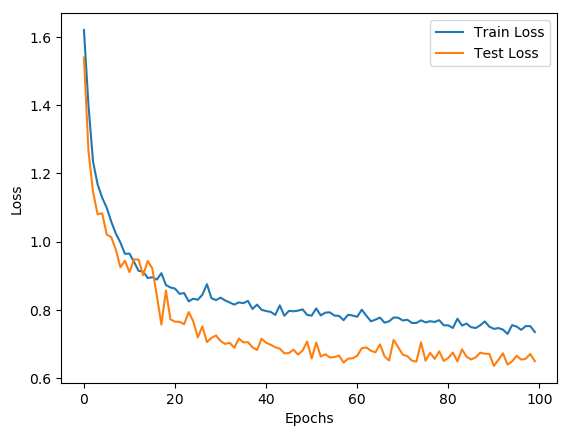

In [131]:
sns.lineplot(x=range(epochs), y=train_losses, label='Train Loss')
sns.lineplot(x=range(epochs), y=test_losses, label='Test Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

In [133]:
save_model(model, 'gcn.safetensors')